#### NES for behavioral cloning of (state, action) pairs 

In [1]:
import numpy as np
from numpy import pi, inf 
import pandas as pd
import matplotlib.pyplot as plt
import pickle 

---

**Baseline: Linear regression**

In [2]:
from sklearn.linear_model import LinearRegression, Ridge

In [86]:
bc_id = 4

# Load data 
X, S, Y = pickle.load(open(f"bc_data/{bc_id}.pkl", "rb"))
X = np.array(X)
S = np.array(S)
Y = np.array(Y)
print(len(X), "total examples")

# Remove examples where robot is too close to wall 
idx = np.argwhere(S.min(axis=1)>1).flatten()  # examples where far away from wall
X = X[idx]
Y = Y[idx]
print(len(X), "valid examples")

# Shuffle 
perm = np.random.permutation(len(X))
X = X[perm]
Y = Y[perm]

# Train-test split 
n_train = int(0.8 * len(X))  # ca. 80%
n_test = len(X) - n_train    # ca. 20%
X_train, X_test = X[:n_train], X[n_train:]
Y_train, Y_test = Y[:n_train], Y[n_train:]

X_train_unnorm = X_train.copy()
X_test_unnorm = X_test.copy()

# Standardize 
x_mean, x_std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train-x_mean)/x_std
X_test = (X_test-x_mean)/x_std 
y_mean, y_std = Y_train.mean(axis=0), Y_train.std(axis=0)
# Y_train = (Y_train-y_mean)/y_std
# Y_test = (Y_test-y_mean)/y_std

# Append constant to entries in X (to allow for bias!)
X_train = np.hstack([np.ones((len(X_train), 1)), X_train])  
X_test = np.hstack([np.ones((len(X_test), 1)), X_test])  
X_train_unnorm = np.hstack([np.ones((len(X_train_unnorm), 1)), X_train_unnorm])  
X_test_unnorm = np.hstack([np.ones((len(X_test_unnorm), 1)), X_test_unnorm])  

107401 total examples
96242 valid examples


In [87]:
model = LinearRegression(fit_intercept=False).fit(X_train, Y_train)
# model = Ridge(fit_intercept=False).fit(X_train, Y_train)

In [5]:
Y_pred = model.predict(X_test)
model.score(X_test, Y_test)  # R^2 score 

0.24299631194425608

In [6]:
model.coef_

array([ 2.38377747e-02, -2.09071096e-04, -8.93360178e-05,  3.66934763e-05,
       -1.08423144e-04,  2.42656506e-02,  4.44684236e-03,  3.31734703e-04,
       -3.90228242e-04,  2.11194785e-04, -2.02055070e-04,  4.14116079e-04,
       -2.35740638e-04, -1.48795195e-04,  6.32485106e-05,  1.33676341e-04,
       -2.68340091e-04])

In [ ]:
# np.save("weights/___.npy", w_norm)

---

**NES**

In [88]:
NUM_OFFSPRING = 10
NUM_GENERATIONS = 2000
LR_MEAN = 0.01
LR_LOGSTD = 0.01
NUM_FEATURES = X_train.shape[1]

In [90]:
def nn(X_train, w):
    """
    Neural network
    """
    return (w @ X_train.T)

In [83]:
def evolve(): 
    # Search distribution 
    search_mean = np.zeros(NUM_FEATURES)  # "parent mean"
    search_logstd = -2.0 * np.ones(NUM_FEATURES)  # log std = -2.0 => std ≈ 0.14
    search_logstd = np.zeros(NUM_FEATURES)  # "parent log std"
    
    f = -inf * np.ones(NUM_OFFSPRING)  # fitness scores 
    loggrad_mean = np.zeros((NUM_OFFSPRING, NUM_FEATURES))
    loggrad_logstd = np.zeros((NUM_OFFSPRING, NUM_FEATURES))
    
    history = []
    
    # Run evolution
    for g in range(NUM_GENERATIONS):
        # print("Generation", g)
        search_std = np.exp(search_logstd)
        # Create and evaluate offspring 
        for i in range(NUM_OFFSPRING):
            # Sample 
            w = search_mean + search_std * np.random.randn(NUM_FEATURES) 
            # Evaluate 
            f[i] = evaluate(w) 
            # Log-gradients of search parameters 
            loggrad_mean[i] = (w-search_mean)/np.multiply(search_std, search_std)
            loggrad_logstd[i] = np.multiply(w-search_mean, w-search_mean)/np.multiply(search_std, search_std)-1
        
        # Normalize fitness scores
        unnorm_f = f
        f = (f-np.mean(f))/(np.std(f)+1e-8)
        
        # Gradients of expected fitness
        grad_J_mean = (f[:, None] * loggrad_mean).mean(axis=0)
        grad_J_logstd = (f[:, None] * loggrad_logstd).mean(axis=0)

        # Fisher matrices
        fisher_mean = np.diag((loggrad_mean ** 2).mean(axis=0))
        fisher_logstd = np.diag((loggrad_logstd ** 2).mean(axis=0))
        
        # Update search parameters 
        search_mean += LR_MEAN * (np.linalg.inv(fisher_mean) @ grad_J_mean)
        search_logstd += LR_LOGSTD * (np.linalg.inv(fisher_logstd) @ grad_J_logstd)

        history.append(unnorm_f.max())
    
    return search_mean, history 

def evaluate(w): 
    """
    Negative mean squared error 
    """
    Y_pred = nn(X_train, w)
    score = -(np.linalg.norm(Y_train-Y_pred)**2).mean().item() 
    score += np.random.normal(0, 10000)  # say, evaluation function is noisy!! 
    return score 

In [91]:
w, history = evolve()

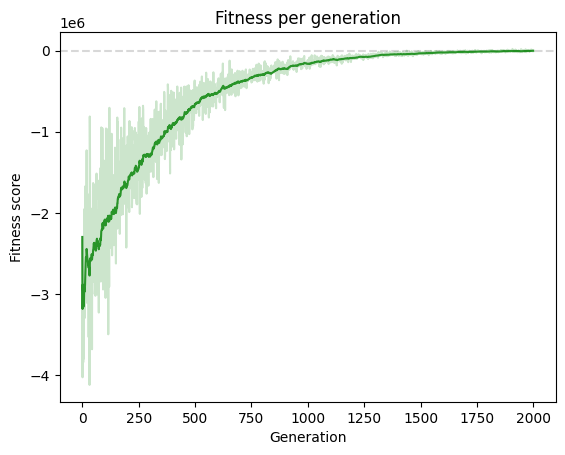

In [92]:
plt.title("Fitness per generation")
plt.xlabel("Generation")
plt.ylabel("Fitness score")
plt.axhline(0, color="grey", ls="--", alpha=0.3)
plt.plot(history, color="green", alpha=0.2)
plt.plot(pd.Series(history).ewm(alpha=0.05).mean(), color="green", alpha=0.8)